In [1]:
import sys
sys.path.insert(0, "../src")

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

import sys
if '..' not in sys.path:
    sys.path.append('..')

from probabilistic_model import ProbabilisticModel

In [2]:
def get_feature_names():
    '''Method for generating feature names for ACSFs and Steinhardt parameters.'''
    from dscribe.descriptors import ACSF
    from steinhardt import desc_to_index_mapping
    feature_names = []
    acsf = ACSF(
        species=['H', 'O'],
        periodic=False,
        r_cut=5.0,
        g2_params=[[0.5, 1.0],[1.0, 1.0],[1.5, 1.0],[2.0, 1.0],[2.5, 1.0],[3.0, 1.0],[3.5, 1.0],[4.0, 1.0],[4.5, 1.0],[5.0, 1.0]],
        g3_params=[0.5, 1.0, 1.5, 2.0],
        g4_params=[[0.0, 1.0, 1.0],[0.0, 0.5, 1.0],[2.0, 1.0, 1.0],[2.0, 0.5, 1.0],[4.5, 1.0, 1.0],[4.5, 0.5, 1.0],[0.0, 1.0, -1.0],[0.0, 0.5, -1.0],[2.0, 1.0, -1.0],[2.0, 0.5, -1.0],[4.5, 1.0, -1.0],[4.5, 0.5, -1.0]],
        g5_params=[[2.0, 1.0, 1.0],[2.0, 0.5, 1.0],[4.5, 1.0, 1.0],[4.5, 0.5, 1.0],[2.0, 1.0, -1.0],[2.0, 0.5, -1.0],[4.5, 1.0, -1.0],[4.5, 0.5, -1.0]]
    )
    for spec in ['H', 'O']:
        feature_names.append(f'G1 | {spec}')
        for param_set in acsf.g2_params:
                feature_names.append(f'G2 | {spec} | {param_set}')
        for param_set in acsf.g3_params:
            feature_names.append(f'G3 | {spec} | {param_set}')
    for spec in ['H-H', 'H-O', 'O-O']:
        for param_set in acsf.g4_params:
            feature_names.append(f'G4 | {spec} | {param_set}')
        for param_set in acsf.g5_params:
            feature_names.append(f'G5 | {spec} | {param_set}')
    for key in desc_to_index_mapping.keys():
        feature_names.append(key)
    return feature_names

In [3]:
def load_data(state='hda'):
    '''
        Method for loading data for a given state from SCAN and MBpol water models.
        The inputs are environment descriptors and the labels are the water model.
    '''
    scan_acsf_data = np.load(f'../data/descriptors/neigh_16/scan_{state}_acsf.npy')
    scan_stein_data = np.load(f'../data/descriptors/neigh_16/scan_{state}_stein.npy')
    scan_data = np.hstack((scan_acsf_data, scan_stein_data))
    mbpol_acsf_data = np.load(f'../data/descriptors/neigh_16/mbpol_{state}_acsf.npy')
    mbpol_stein_data = np.load(f'../data/descriptors/neigh_16/mbpol_{state}_stein.npy')
    mbpol_data = np.hstack((mbpol_acsf_data, mbpol_stein_data))
    scan_labels = np.zeros(shape=(scan_data.shape[0],))
    mbpol_labels = np.ones(shape=(mbpol_data.shape[0],))
    X = np.vstack((scan_data, mbpol_data))
    y = np.hstack((scan_labels, mbpol_labels))
    np.random.seed(1)
    idx = [i for i in range(X.shape[0])]
    np.random.shuffle(idx)
    X = X[idx]
    y = y[idx]
    return X, y

In [4]:
# Load features for HDA environments for both models.
X_hda, y_hda = load_data(state='hda')

In [5]:
# Assess accuracy of model for classifying HDA environments from different water models.
accs = []
kf = KFold(n_splits=5, shuffle=True, random_state=1)
for idx, (train_idx, test_idx) in enumerate(kf.split(X_hda)):
    print(f'Evaluating fold {idx + 1} / 5.')
    X_train = X_hda[train_idx]
    y_train = y_hda[train_idx]
    X_test = X_hda[test_idx]
    y_test = y_hda[test_idx]
    model = ProbabilisticModel(
        max_features=5, 
        include=0.98,
        detect_outliers=False,
        corr_cut=0.8
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test, binary=True)   # Only consider HDA/LDA predictions.
    accs.append(accuracy_score(y_test, y_pred))

print(f'Accuracy = {np.mean(accs):.3f} +/- {np.std(accs):.3f}')

Evaluating fold 1 / 5.
Evaluating fold 2 / 5.
Evaluating fold 3 / 5.
Evaluating fold 4 / 5.
Evaluating fold 5 / 5.
Accuracy = 0.643 +/- 0.025


In [8]:
# Train model on HDA environments.
model = ProbabilisticModel(
    max_features=5, 
    include=0.98,
    detect_outliers=False,
    corr_cut=0.8
)
model.fit(X_hda, y_hda)
key_features = model.chosen_features

feature_names = get_feature_names()
for idx, feat in enumerate(key_features):
    print(f'{feature_names[feat]}, {model.mutual_information[idx]}')

G5 | H-H | [4.5, 0.5, -1.0], 0.08438943201617698
G2 | O | [3.0, 1.0], 0.062424064694056605
G2 | H | [5.0, 1.0], 0.05903118724622811
G2 | O | [0.5, 1.0], 0.0547907415448325
G4 | H-H | [2.0, 1.0, -1.0], 0.053631299312733076


In [9]:
# Load features for HDA environments for both models.
X_lda, y_lda = load_data(state='lda')

In [10]:
# Assess accuracy of model for classifying HDA environments from different water models.
accs = []
kf = KFold(n_splits=5, shuffle=True, random_state=1)
for idx, (train_idx, test_idx) in enumerate(kf.split(X_lda)):
    print(f'Evaluating fold {idx + 1} / 5.')
    X_train = X_lda[train_idx]
    y_train = y_lda[train_idx]
    X_test = X_lda[test_idx]
    y_test = y_lda[test_idx]
    model = ProbabilisticModel(
        max_features=5, 
        include=0.98, 
        detect_outliers=False,
        corr_cut=0.8
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test, binary=True)   # Only consider HDA/LDA predictions.
    accs.append(accuracy_score(y_test, y_pred))

print(f'Accuracy = {np.mean(accs):.3f} +/- {np.std(accs):.3f}')

Evaluating fold 1 / 5.
Evaluating fold 2 / 5.
Evaluating fold 3 / 5.
Evaluating fold 4 / 5.
Evaluating fold 5 / 5.
Accuracy = 0.775 +/- 0.003


In [37]:
# Train model on LDA environments.
model = ProbabilisticModel(
    max_features=5, 
    include=0.98,
    detect_outliers=False,
    corr_cut=0.8,
    use_features=[i for i in range(90,120)]
)
model.fit(X_lda, y_lda)
key_features = model.chosen_features

feature_names = get_feature_names()
for idx, feat in enumerate(key_features):
    print(f'{feature_names[feat]}, {model.mutual_information[idx]}')

q3, 0.03756554383962938
q4, 0.0032824869198125675
q5, 0.0017732150268757645
q6, 0.0017579011251070353
q7, 0.0027436554837261254
q8, 0.0029210405255866733
q9, 0.009864007737953526
q10, 0.009043772743302488
q11, 0.0018091129665468533
q12, 0.0067483615643480965
av_q3, 0.014887568528333629
av_q4, 0.030355033687094937
av_q5, 0.004726191417919638
av_q6, 0.004842929931653108
av_q7, 0.0024975448669449633
av_q8, 0.004919405141867537
av_q9, 0.01314211038273323
av_q10, 0.018212820290664563
av_q11, 0.002765090108435514
av_q12, 0.0299234383111773
w4, 0.004951526487079799
w6, 0.0014344525115864014
w8, 0.0011974011429200754
w10, 0.0011800807062339708
w12, 0.001829763828182573
av_w4, 0.0009179525438142696
av_w6, 0.0014450751978723063
av_w8, 0.001480602927806085
av_w10, 0.001628232159783623
av_w12, 0.000832212906991928


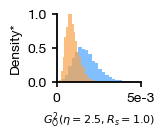

In [32]:
# Get distributions of LDA environments from SCAN and MBpol models on first chosen descriptor.
chosen_descriptor = key_features[0]
scan_idx = np.argwhere(y_lda == 0).reshape(-1)
mbpol_idx = np.argwhere(y_lda == 1).reshape(-1)
scan_dist = X_lda[scan_idx, chosen_descriptor]
mbpol_dist = X_lda[mbpol_idx, chosen_descriptor]

# Compute histograms and normalize to reasonable y-value.
scan_hist, scan_edges = np.histogram(scan_dist, bins=30, density=True)
mbpol_hist, mbpol_edges = np.histogram(mbpol_dist, bins=30, density=True)
norm_factor = max(np.max(scan_hist), np.max(mbpol_hist))
scan_hist /= norm_factor
mbpol_hist /= norm_factor

# Visualize the first considered function.
plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.3
fig, ax = plt.subplots(1,1,figsize=(1.75,1.5))

# Compute the first ACSF.
ax.stairs(scan_hist, scan_edges, color="#4DA5FE", alpha=0.7, fill=True)
ax.stairs(mbpol_hist, mbpol_edges, color="#F9A54B", alpha=0.7, fill=True)

ax.set_xlabel(r'$G_{\text{O}}^{2}(\eta=2.5, R_{s}=1.0)$', size=8)
ax.set_ylabel('Density*')
ax.set_xlim(xmin=0.0, xmax=0.005)
ax.set_ylim(ymin=0.0, ymax=1.0)
ax.set_xticks(ticks=[0.0000, 0.005], labels=['0', '5e-3'])
ax.set_yticks(ticks=[0.0, 0.5, 1.0])
ax.tick_params(axis='both', width=1.2, length=3.6)
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.savefig('./figures/lda_1_dist.svg', dpi=1000, transparent=True)
plt.show()

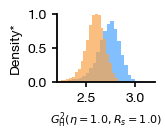

In [34]:
# Get distributions of LDA environments from SCAN and MBpol models on second chosen descriptor.
chosen_descriptor = key_features[1]
scan_idx = np.argwhere(y_lda == 0).reshape(-1)
mbpol_idx = np.argwhere(y_lda == 1).reshape(-1)
scan_dist = X_lda[scan_idx, chosen_descriptor]
mbpol_dist = X_lda[mbpol_idx, chosen_descriptor]

# Compute histograms and normalize to reasonable y-value.
scan_hist, scan_edges = np.histogram(scan_dist, bins=30, density=True)
mbpol_hist, mbpol_edges = np.histogram(mbpol_dist, bins=30, density=True)
norm_factor = max(np.max(scan_hist), np.max(mbpol_hist))
scan_hist /= norm_factor
mbpol_hist /= norm_factor

# Visualize the first considered function.
plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.3
fig, ax = plt.subplots(1,1,figsize=(1.75,1.5))

# Compute the first ACSF.
ax.stairs(scan_hist, scan_edges, color="#4DA5FE", alpha=0.7, fill=True)
ax.stairs(mbpol_hist, mbpol_edges, color="#F9A54B", alpha=0.7, fill=True)

ax.set_xlabel(r'$G_{\text{H}}^{2}(\eta=1.0, R_{s}=1.0)$', size=8)
ax.set_ylabel('Density*')
ax.set_xlim(xmin=2.2, xmax=3.2)
ax.set_ylim(ymin=0.0, ymax=1.0)
ax.set_xticks(ticks=[2.5,3.0])
ax.set_yticks(ticks=[0.0, 0.5, 1.0])
ax.tick_params(axis='both', width=1.2, length=3.6)
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.savefig('./figures/lda_2_dist.svg', dpi=1000, transparent=True)
plt.show()

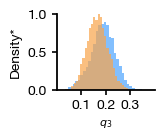

In [40]:
# Get distributions of LDA environments from SCAN and MBpol models on second chosen descriptor.
chosen_descriptor = 90
scan_idx = np.argwhere(y_lda == 0).reshape(-1)
mbpol_idx = np.argwhere(y_lda == 1).reshape(-1)
scan_dist = X_lda[scan_idx, chosen_descriptor]
mbpol_dist = X_lda[mbpol_idx, chosen_descriptor]

# Compute histograms and normalize to reasonable y-value.
scan_hist, scan_edges = np.histogram(scan_dist, bins=30, density=True)
mbpol_hist, mbpol_edges = np.histogram(mbpol_dist, bins=30, density=True)
norm_factor = max(np.max(scan_hist), np.max(mbpol_hist))
scan_hist /= norm_factor
mbpol_hist /= norm_factor

# Visualize the first considered function.
plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.3
fig, ax = plt.subplots(1,1,figsize=(1.75,1.5))

# Compute the first ACSF.
ax.stairs(scan_hist, scan_edges, color="#4DA5FE", alpha=0.7, fill=True)
ax.stairs(mbpol_hist, mbpol_edges, color="#F9A54B", alpha=0.7, fill=True)

ax.set_xlabel(r'$q_{3}$', size=8)
ax.set_ylabel('Density*')
ax.set_xlim(xmin=0.0, xmax=0.4)
ax.set_ylim(ymin=0.0, ymax=1.0)
ax.set_xticks(ticks=[0.1,0.2,0.3])
ax.set_yticks(ticks=[0.0, 0.5, 1.0])
ax.tick_params(axis='both', width=1.2, length=3.6)
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.savefig('./figures/lda_3_dist.svg', dpi=1000, transparent=True)
plt.show()

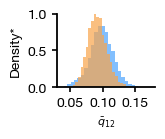

In [47]:
# Get distributions of LDA environments from SCAN and MBpol models on second chosen descriptor.
chosen_descriptor = 109
scan_idx = np.argwhere(y_lda == 0).reshape(-1)
mbpol_idx = np.argwhere(y_lda == 1).reshape(-1)
scan_dist = X_lda[scan_idx, chosen_descriptor]
mbpol_dist = X_lda[mbpol_idx, chosen_descriptor]

# Compute histograms and normalize to reasonable y-value.
scan_hist, scan_edges = np.histogram(scan_dist, bins=30, density=True)
mbpol_hist, mbpol_edges = np.histogram(mbpol_dist, bins=30, density=True)
norm_factor = max(np.max(scan_hist), np.max(mbpol_hist))
scan_hist /= norm_factor
mbpol_hist /= norm_factor

# Visualize the first considered function.
plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.3
fig, ax = plt.subplots(1,1,figsize=(1.75,1.5))

# Compute the first ACSF.
ax.stairs(scan_hist, scan_edges, color="#4DA5FE", alpha=0.7, fill=True)
ax.stairs(mbpol_hist, mbpol_edges, color="#F9A54B", alpha=0.7, fill=True)

ax.set_xlabel(r'$\bar{q}_{12}$', size=8)
ax.set_ylabel('Density*')
ax.set_xlim(xmin=0.03, xmax=0.18)
ax.set_ylim(ymin=0.0, ymax=1.0)
ax.set_xticks(ticks=[0.05, 0.10, 0.15])
ax.set_yticks(ticks=[0.0, 0.5, 1.0])
ax.tick_params(axis='both', width=1.2, length=3.6)
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.savefig('./figures/lda_4_dist.svg', dpi=1000, transparent=True)
plt.show()

In [3]:
data = np.load(f'./data/averaged_rdf_data_80K.npz')
organized_data = {
    'DP_SCAN': {
        'rdf': {
            'oo': {
                'r': data['DP_SCAN_oo_r'],
                'gr': data['DP_SCAN_oo_gr']
            }
        }
    },
    'DP_MBpol': {
        'rdf': {
            'oo': {
                'r': data['DP_MBpol_oo_r'],
                'gr': data['DP_MBpol_oo_gr']
            }
        }
    }
}
dp_scan_r = organized_data['DP_SCAN']['rdf']['oo']['r']
dp_scan_gr = organized_data['DP_SCAN']['rdf']['oo']['gr']
dp_mbpol_r = organized_data['DP_MBpol']['rdf']['oo']['r']
dp_mbpol_gr = organized_data['DP_MBpol']['rdf']['oo']['gr']

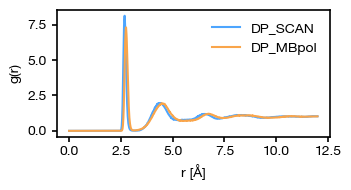

In [22]:
plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.2
fig, ax = plt.subplots(1,1,figsize=(3.5,2.0))
ax.plot(dp_scan_r, dp_scan_gr, label='DP_SCAN', color="#4DA5FE")
ax.plot(dp_mbpol_r, dp_mbpol_gr, label='DP_MBpol', color="#F9A54B")
ax.set_xlabel('r [Å]')
ax.set_ylabel('g(r)')
ax.tick_params(axis='both', width=1.2, length=3.6)
ax.legend(edgecolor='white')
plt.tight_layout()
plt.savefig('./figures/rdf.svg', dpi=1000, transparent=True)
plt.show()